In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:24<00:00, 138MB/s]
100% 2.29G/2.29G [00:24<00:00, 98.6MB/s]


In [2]:
zip_path = '/content/chest-xray-pneumonia.zip'
!unzip -q {zip_path} -d .
!rm {zip_path}
zip_path = '/content/chest_xray.zip'

In [3]:
from PIL import Image

# Load the image
image = Image.open('/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg')

# Get the size of the image
width, height = image.size
print(f"Width: {width}, Height: {height}")

# Check the color mode (e.g., RGB, RGBA, L for grayscale)
color_mode = image.mode
print(f"Color Mode: {color_mode}")

# Display the image
image.show()

Width: 1776, Height: 1416
Color Mode: L


In [4]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, MaxPooling2D, Conv2DTranspose, Conv2D, Concatenate, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [5]:
image_size= 224,224
batch_size=32


In [6]:
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

In [7]:
train_ds = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_ds = ImageDataGenerator(
    rescale=1./255
)
train_ds = ImageDataGenerator(rescale=1./255)


In [8]:
train_gen = train_ds.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
val_gen = val_ds.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_gen = val_ds.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
def u_net(image_size):
    inputs = Input(image_size)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)



    c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    for layer in [c3]:
        layer.trainable = False
    c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    x = GlobalAveragePooling2D()(c9)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)


    model = Model(inputs=[inputs], outputs=[x])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        # Freeze certain layers after the model is built
    for layer in model.layers[:10]:  # Modify the index range to freeze layers as needed
        layer.trainable = False

    return model
model = u_net(image_size=(224, 224, 3))

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 56, 56, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 28, 28, 512)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 31,065,473 (118.51 MB)

 Trainable params: 30,510,145 (116.39 MB)

 Non-trainable params: 555,328 (2.12 MB)

In [25]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen,

)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.8980 - loss: 0.2561

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8979 - loss: 0.2561 - val_accuracy: 0.6955 - val_loss: 0.7945
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8974 - loss: 0.2399 - val_accuracy: 0.7692 - val_loss: 0.5225
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.8921 - loss: 0.2597 - val_accuracy: 0.7163 - val_loss: 0.7480
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9026 - loss: 0.2334 - val_accuracy: 0.8077 - val_loss: 0.4471
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9087 - loss: 0.2362 - val_accuracy: 0.7260 - val_loss: 0.5571
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9141 - loss: 0.2074 - val_accuracy: 0.7804 - val_loss: 0.5369
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8979 - loss: 0.2501 - val_accuracy: 0.7003 - val_loss: 0.8205
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9070 - loss: 0.2288 - val_accuracy: 0.698

In [11]:
print(len(train_gen))
print(len(val_gen))


163
1


In [12]:
print(train_gen.class_indices)  # Verify class indices
print(val_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [13]:
input_shape = model.input_shape
print(f"Input shape: {input_shape}")

Input shape: (None, 224, 224, 3)


In [14]:
model.save('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Normal (Probability:  0.150786)


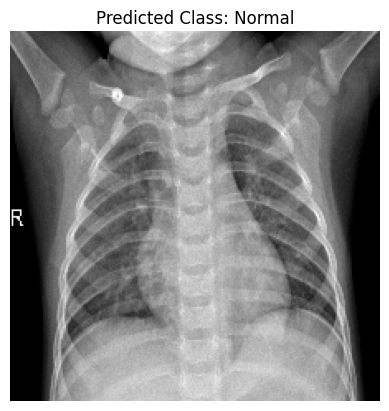

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def process_image(image_path, image_size):
    img = image.load_img(image_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize
    return img_array

# Path to the image and target size
img_path = '/content/chest_xray/train/NORMAL/IM-0145-0001.jpeg'
image_size = (224, 224)  # Match this to the input size expected by the model

# Process the image
img_array = process_image(img_path, image_size)

# Predict
predictions = model.predict(img_array)
predicted_prob = predictions[0,0]
predicted_class = "PNEUMONIA" if predicted_prob > 0.5 else "Normal"
# Assuming the output is a single channel and you want a binary prediction
print(f"Predicted Class: {predicted_class} (Probability: {predicted_prob: 2f})")


# Load and display the image
img = image.load_img(img_path, target_size=image_size)
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()
